In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


loan = pd.read_csv('accepted_2007_to_2018Q4.csv')

return_number = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

def convert_date(d):
    try:
        return datetime.date(year=int(d[4:]), month=return_number[d[:3]], day=1)
    except:
        pass

loan['issue_d'] = loan['issue_d'].apply(convert_date)
loan['earliest_cr_line'] = loan['earliest_cr_line'].apply(convert_date)

loan = loan[loan.issue_d < datetime.date(2015,7,1)]
loan = loan[loan.issue_d >= datetime.date(2010,1,1)]

loan = loan[loan.term == ' 36 months']

loan['earliest_cr_line'] = loan.apply(lambda x: (x['issue_d'] - x['earliest_cr_line']).days, axis=1)

loan = loan[(loan.loan_status == 'Fully Paid') | (loan.loan_status == 'Charged Off')]

loan = loan[loan.annual_inc < 1000000]

loan['ln_annual_inc'] = np.log(loan.annual_inc)

loan = loan[loan.revol_util < 150]
loan['ln_revol_bal'] = np.log(loan.revol_bal+1)

loan['ln_earliest_cr_line'] = np.log(loan.earliest_cr_line)

loan['ln_open_acc'] = np.log(loan.open_acc)

loan.rename(columns = {'delinq_2yrs': 'num_delinq_2yrs'}, inplace=True)
loan['delinq_2yrs'] = (loan['num_delinq_2yrs'] >= 1)

loan.rename(columns = {'pub_rec': 'num_pub_rec'}, inplace=True)
loan['pub_rec'] = (loan['num_pub_rec'] >= 1)

loan.rename(columns = {'inq_last_6mths': 'num_inq_last_6mths'}, inplace=True)
loan['inq_last_6mths'] = (loan['num_inq_last_6mths'] >= 1)

loan['target'] = (loan['loan_status'] == 'Fully Paid')

In [3]:
col_list = ['loan_amnt', 'int_rate', 'ln_annual_inc', 'dti', 'fico_range_high', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'num_inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'ln_open_acc', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']


In [4]:
# We will use 2010-2013 to tune our models, and save data from 2014 and the first 
# 6 months of 2015 for walk-forward testing

train = loan[loan.issue_d < datetime.date(2014, 1, 1)]
test = loan[(loan.issue_d >= datetime.date(2014, 1, 1)) & (loan.issue_d < datetime.date(2015, 7, 1))]


In [5]:
loan.shape

(449486, 159)

In [6]:
train.shape

(166313, 159)

In [7]:
print('2010: {}'.format(sum([x.year == 2010 for x in train.issue_d])))
print('2011: {}'.format(sum([x.year == 2011 for x in train.issue_d])))
print('2012: {}'.format(sum([x.year == 2012 for x in train.issue_d])))
print('2013: {}'.format(sum([x.year == 2013 for x in train.issue_d])))

2010: 8445
2011: 14092
2012: 43423
2013: 100353


In [8]:
import statsmodels.api as sm

y = train['target']
X1 = train[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2 = pd.concat([X1, train.int_rate, pd.get_dummies(train.grade)], axis=1)
X3 = pd.concat([X1, train.int_rate, pd.get_dummies(train.sub_grade)], axis=1)
X1 = sm.add_constant(X1)


In [9]:
type(y)

pandas.core.series.Series

In [10]:
type(X1)

pandas.core.frame.DataFrame

In [11]:
X1.shape

(166313, 16)

In [12]:
import statsmodels.discrete as smd

logit = smd.discrete_model.Logit(y, X1.astype(float)).fit()
logit_me = logit.get_margeff()
logit_me.summary()

Optimization terminated successfully.
         Current function value: 0.359305
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -2.459e-06   1.38e-07    -17.878      0.000   -2.73e-06   -2.19e-06
ln_annual_inc           0.0621      0.002     29.539      0.000       0.058       0.066
dti                    -0.0015      0.000    -11.829      0.000      -0.002      -0.001
fico_range_high         0.0012    3.8e-05     32.077      0.000       0.001       0.001
delinq_2yrs             0.0088      0.004      2.480      0.013       0.002       0.016
num_delinq_2yrs        -0.0017      0.002     -0.955      0.340      -0.005       0.002
ln_earliest_cr_line    -0.0023      0.002     -1.224      0.221      -0.006       0.001
inq_last_6mths         -0.0065      0.003     -2.528      0.011      -0.012      -0.001
num_inq_last_6mths     -0.0171      0.001    -14.271      0.000      -0.020      -0.015
ln_open_acc            -0.0215      0.003     -8.045      0.000      -0.027      -0.016
pub_rec                 0.0133      0.005      2.894      0.004       0.004       0.022
num_pub_rec          1.869e-05      0.003      0.006      0.995      -0.006       0.006
ln_revol_bal            0.0132      0.001     14.761      0.000       0.011       0.015
revol_util             -0.0004   4.85e-05     -9.023      0.000      -0.001      -0.000
total_acc               0.0009      0.000      7.896      0.000       0.001       0.001
=======================================================================================
"""

In [13]:
logit2 = smd.discrete_model.Logit(y, X2.astype(float)).fit()
logit2_me = logit2.get_margeff()
logit2_me.summary()

Optimization terminated successfully.
         Current function value: 0.356435
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.867e-06   1.36e-07    -13.773      0.000   -2.13e-06    -1.6e-06
ln_annual_inc           0.0576      0.002     27.607      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.397      0.000      -0.001      -0.001
fico_range_high         0.0005   4.56e-05     10.062      0.000       0.000       0.001
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0009      0.002     -0.513      0.608      -0.004       0.003
ln_earliest_cr_line    -0.0037      0.002     -1.957      0.050      -0.007     6.2e-06
inq_last_6mths          0.0011      0.003      0.421      0.674      -0.004       0.006
num_inq_last_6mths     -0.0119      0.001     -9.868      0.000      -0.014      -0.010
ln_open_acc            -0.0206      0.003     -7.772      0.000      -0.026      -0.015
pub_rec                 0.0092      0.005      1.826      0.068      -0.001       0.019
num_pub_rec             0.0017      0.004      0.456      0.649      -0.006       0.009
ln_revol_bal            0.0087      0.001      9.408      0.000       0.007       0.010
revol_util             -0.0002   4.88e-05     -3.916      0.000      -0.000   -9.55e-05
total_acc               0.0007      0.000      6.056      0.000       0.000       0.001
int_rate               -0.0076      0.001    -10.963      0.000      -0.009      -0.006
A                      -0.5860      0.042    -14.012      0.000      -0.668      -0.504
B                      -0.5968      0.042    -14.371      0.000      -0.678      -0.515
C                      -0.6046      0.042    -14.421      0.000      -0.687      -0.522
D                      -0.6074      0.043    -14.236      0.000      -0.691      -0.524
E                      -0.5986      0.044    -13.729      0.000      -0.684      -0.513
F                      -0.5958      0.045    -13.262      0.000      -0.684      -0.508
G                      -0.6173      0.053    -11.675      0.000      -0.721      -0.514
=======================================================================================
"""

In [14]:
logit3 = smd.discrete_model.Logit(y, X3.astype(float)).fit()
logit3_me = logit3.get_margeff()
logit3_me.summary()

         Current function value: 0.356164
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                 target
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
loan_amnt           -1.786e-06   1.36e-07    -13.139      0.000   -2.05e-06   -1.52e-06
ln_annual_inc           0.0574      0.002     27.554      0.000       0.053       0.062
dti                    -0.0012      0.000     -9.379      0.000      -0.001      -0.001
fico_range_high         0.0004   4.68e-05      8.173      0.000       0.000       0.000
delinq_2yrs             0.0079      0.004      2.223      0.026       0.001       0.015
num_delinq_2yrs        -0.0010      0.002     -0.535      0.592      -0.004       0.003
ln_earliest_cr_line    -0.0046      0.002     -2.418      0.016      -0.008      -0.001
inq_last_6mths          0.0018      0.003      0.688      0.492      -0.003       0.007
num_inq_last_6mths     -0.0117      0.001     -9.677      0.000      -0.014      -0.009
ln_open_acc            -0.0215      0.003     -8.106      0.000      -0.027      -0.016
pub_rec                 0.0091      0.005      1.799      0.072      -0.001       0.019
num_pub_rec             0.0017      0.004      0.464      0.643      -0.006       0.009
ln_revol_bal            0.0082      0.001      8.902      0.000       0.006       0.010
revol_util             -0.0002   4.89e-05     -3.504      0.000      -0.000   -7.54e-05
total_acc               0.0007      0.000      6.117      0.000       0.000       0.001
int_rate               -0.0036      0.001     -3.128      0.002      -0.006      -0.001
A1                     -0.5055      0.044    -11.454      0.000      -0.592      -0.419
A2                     -0.5248      0.043    -12.122      0.000      -0.610      -0.440
A3                     -0.5403      0.043    -12.593      0.000      -0.624      -0.456
A4                     -0.5571      0.042    -13.125      0.000      -0.640      -0.474
A5                     -0.5650      0.042    -13.341      0.000      -0.648      -0.482
B1                     -0.5699      0.042    -13.453      0.000      -0.653      -0.487
B2                     -0.5714      0.042    -13.472      0.000      -0.655      -0.488
B3                     -0.5765      0.043    -13.561      0.000      -0.660      -0.493
B4                     -0.5831      0.043    -13.657      0.000      -0.667      -0.499
B5                     -0.5907      0.043    -13.777      0.000      -0.675      -0.507
C1                     -0.5924      0.043    -13.766      0.000      -0.677      -0.508
C2                     -0.5964      0.043    -13.772      0.000      -0.681      -0.512
C3                     -0.6077      0.044    -13.960      0.000      -0.693      -0.522
C4                     -0.6104      0.044    -13.957      0.000      -0.696      -0.525
C5                     -0.6041      0.044    -13.692      0.000      -0.691      -0.518
D1                     -0.6180      0.044    -13.930      0.000      -0.705      -0.531
D2                     -0.6159      0.045    -13.775      0.000      -0.704      -0.528
D3                     -0.6157      0.045    -13.676      0.000      -0.704      -0.527
D4                     -0.6231      0.045    -13.766      0.000      -0.712      -0.534
D5                     -0.6109      0.046    -13.356      0.000      -0.701      -0.521
E1                     -0.6147      0.046    -13.310      0.000      -0.705      -0.524
E2                     -0.6233      0.047    -13.361      0.000      -0.715      -0.532
E3                     -0.6136      0.047    -13.008      0.000      -0.706      -0.521
E4                     -0.6209      0.048    -12.993      0.000   

In [15]:
X1_test = test[['loan_amnt', 'ln_annual_inc', 'dti', 'fico_range_high', 'delinq_2yrs', 'num_delinq_2yrs', 'ln_earliest_cr_line', 'inq_last_6mths', 'num_inq_last_6mths', 'ln_open_acc', 'pub_rec', 'num_pub_rec', 'ln_revol_bal', 'revol_util', 'total_acc']]
X2_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.grade)], axis=1)
X3_test = pd.concat([X1_test, test.int_rate, pd.get_dummies(test.sub_grade)], axis=1)
X1_test = sm.add_constant(X1_test)
y_test = test['target']

test['pred'] = logit.predict(X1_test.astype(float))
test['pred2'] = logit2.predict(X2_test.astype(float))
test['pred3'] = logit3.predict(X3_test.astype(float))

In [39]:
X2_test.isnull().sum()

loan_amnt              0
ln_annual_inc          0
dti                    0
fico_range_high        0
delinq_2yrs            0
num_delinq_2yrs        0
ln_earliest_cr_line    0
inq_last_6mths         0
num_inq_last_6mths     0
ln_open_acc            0
pub_rec                0
num_pub_rec            0
ln_revol_bal           0
revol_util             0
total_acc              0
int_rate               0
A                      0
B                      0
C                      0
D                      0
E                      0
F                      0
G                      0
dtype: int64

In [16]:
sum_stats = train.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target']].mean()
sum_stats_test = test.groupby(['grade'])[['int_rate', 'annual_inc', 'fico_range_high', 'dti', 'loan_amnt', 'target','pred', 'pred2', 'pred3']].mean()
comparison = pd.merge(sum_stats, sum_stats_test, on=['grade'])[['int_rate_x', 'target_x', 'int_rate_y', 'target_y', 'pred', 'pred2', 'pred3']]
comparison.rename(columns={'int_rate_x': 'int_rate_train',
                           'target_x': 'compliance_train',
                           'int_rate_y': 'int_rate_test',
                           'target_y': 'compliance_test'
                          }, inplace=True)
comparison

,int_rate_train,compliance_train,int_rate_test,compliance_test,pred,pred2,pred3
grade,,,,,,,
A,7.533552,0.943643,7.257456,0.944358,0.917446,0.942881,0.942637
B,11.784927,0.894520,10.776167,0.887245,0.878406,0.901482,0.897536
C,15.175030,0.842224,13.752072,0.820389,0.850389,0.856179,0.848309
D,18.259644,0.797595,16.856570,0.761690,0.830258,0.807749,0.798779
E,20.967960,0.774016,19.899155,0.709688,0.817479,0.774749,0.766657
F,23.139601,0.740024,24.083902,0.675883,0.806044,0.714623,0.713314
G,23.226515,0.727273,25.856337,0.641026,0.780693,0.615993,0.634662


In [17]:
test.groupby(['grade']).count()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_title,...,ln_revol_bal,ln_earliest_cr_line,ln_open_acc,delinq_2yrs,pub_rec,inq_last_6mths,target,pred,pred2,pred3
grade,,,,,,,,,,,,,,,,,,,,,
A,65921,0,65921,65921,65921,65921,65921,65921,65921,62830,...,65921,65921,65921,65921,65921,65921,65921,65921,65921,65921
B,89158,0,89158,89158,89158,89158,89158,89158,89158,83849,...,89158,89158,89158,89158,89158,89158,89158,89158,89158,89158
C,77668,0,77668,77668,77668,77668,77668,77668,77668,72331,...,77668,77668,77668,77668,77668,77668,77668,77668,77668,77668
D,35865,0,35865,35865,35865,35865,35865,35865,35865,32845,...,35865,35865,35865,35865,35865,35865,35865,35865,35865,35865
E,11684,0,11684,11684,11684,11684,11684,11684,11684,10592,...,11684,11684,11684,11684,11684,11684,11684,11684,11684,11684
F,2604,0,2604,2604,2604,2604,2604,2604,2604,2318,...,2604,2604,2604,2604,2604,2604,2604,2604,2604,2604
G,273,0,273,273,273,273,273,273,273,244,...,273,273,273,273,273,273,273,273,273,273


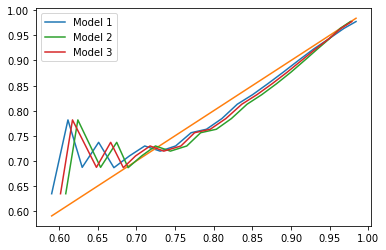

In [18]:
pred = []
act = []
pred2 = []
pred3 = []

for i in range(21):
    min = .58 + i*.02
    max = .58 + (i+1)*.02
    df = test[(test['pred'] >= min)&(test['pred'] < max)]
    pred_compliance = df['pred'].mean()
    act_compliance = df['target'].mean()
    pred.append(pred_compliance)
    pred2.append(df['pred2'].mean())
    pred3.append(df['pred3'].mean())
    act.append(act_compliance)
    #print('{} to {}:'.format(round(min,2), round(max,2)))
    #print('sample size: {}'.format(df.shape[0]))
    #print('predicted %: {}'.format(round(pred_compliance, 3)))
    #print('actual %:    {}'.format(round(act_compliance, 3)))
    #print('')
    
plt.plot(pred, act, label='Model 1')
plt.plot(pred, pred)
plt.plot(pred2, act, label='Model 2')
plt.plot(pred3, act, label='Model 3')
plt.legend()
plt.show()

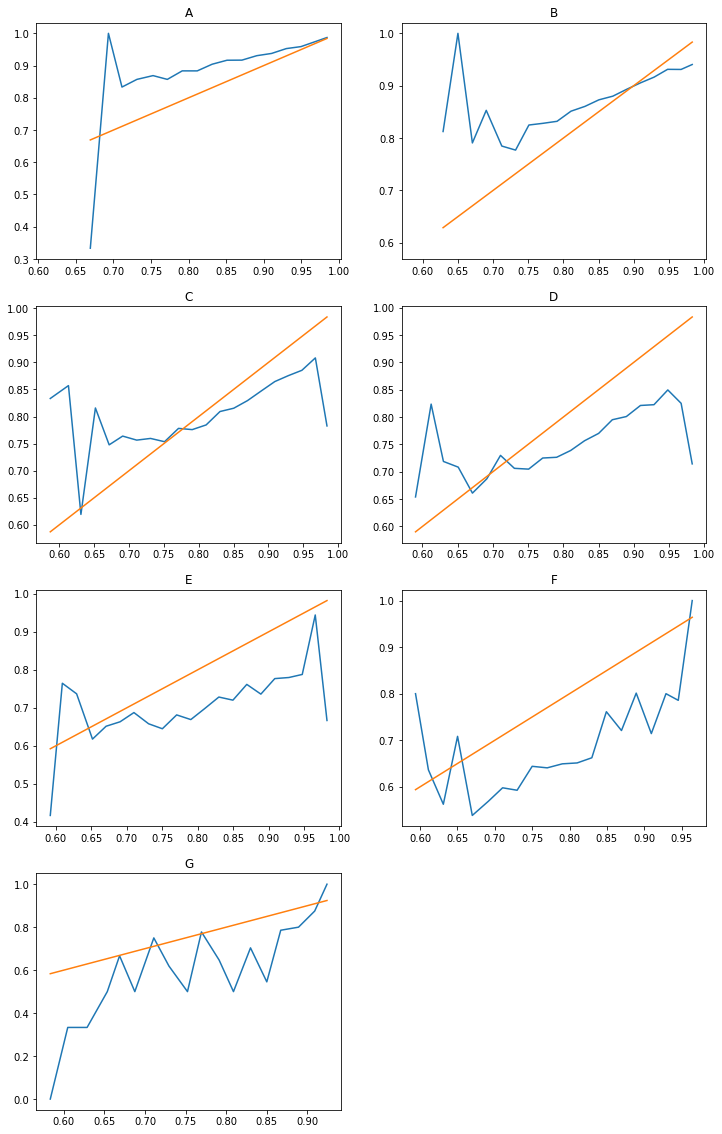

In [19]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize = (12,20))

for letter in range(7):
    pred = []
    act = []
    for i in range(21):
        min = .58 + i*.02
        max = .58 + (i+1)*.02
        df = test[(test['pred'] >= min)&(test['pred'] < max)&(test['grade']==letters[letter])]
        pred_compliance = df['pred'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(4,2,letter+1)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)
plt.show()

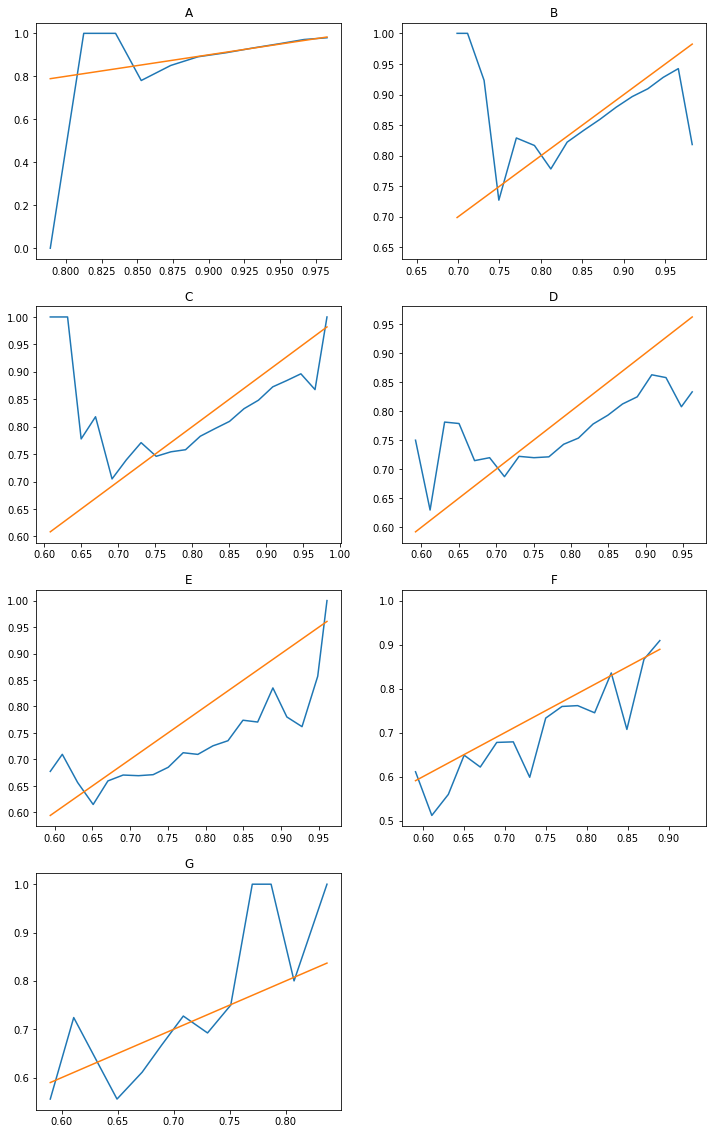

In [20]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

plt.figure(figsize = (12,20))

for letter in range(7):
    pred = []
    act = []
    for i in range(21):
        min = .58 + i*.02
        max = .58 + (i+1)*.02
        df = test[(test['pred2'] >= min)&(test['pred2'] < max)&(test['grade']==letters[letter])]
        pred_compliance = df['pred2'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(4,2,letter+1)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)

plt.show()

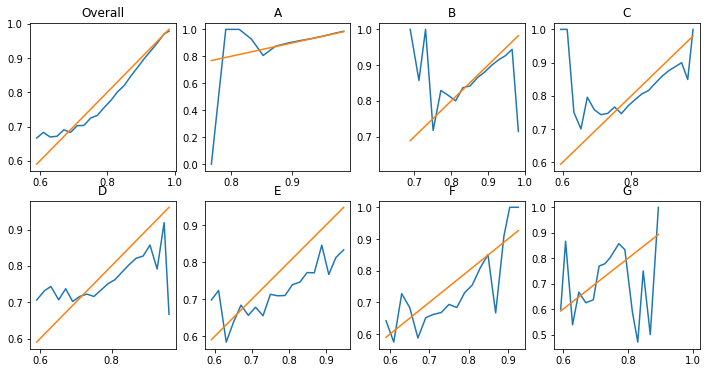

In [21]:
pred = []
act = []
letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']



plt.figure(figsize = (12,6))
plt.subplot(2,4,1)
plt.title('Overall')

for i in range(21):
    lb = .58 + i*.02
    ub = .58 + (i+1)*.02
    df = test[(test['pred3'] >= lb)&(test['pred3'] < ub)]
    pred_compliance = df['pred3'].mean()
    act_compliance = df['target'].mean()
    pred.append(pred_compliance)
    act.append(act_compliance)
plt.plot(pred, act)
plt.plot(pred, pred)

for letter in range(7):
    pred = []
    act = []
    ss = []
    for i in range(21):
        lb = .58 + i*.02
        ub = .58 + (i+1)*.02
        df = test[(test['pred3'] >= lb)&(test['pred3'] < ub)&(test['grade']==letters[letter])]
        pred_compliance = df['pred3'].mean()
        act_compliance = df['target'].mean()
        pred.append(pred_compliance)
        act.append(act_compliance)
    
    plt.subplot(2,4,letter+2)
    plt.title(letters[letter])
    plt.plot(pred, act)
    plt.plot(pred, pred)

plt.show()

In [22]:
ss

[]

In [23]:
sum(test[test.pred >= .98]['target'])/len(test[test.pred >= .98]['target'])

0.9775

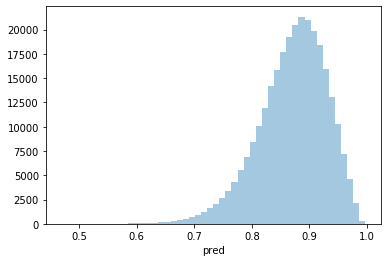

In [24]:
sns.distplot(test['pred'], kde=False)

In [25]:
test['pct_return'] = (test.total_pymnt - test.funded_amnt) / test.funded_amnt

for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['pred'], q=80)
    thresh_m2_80 = np.percentile(test[test.grade == letter]['pred2'], q=80)
    thresh_m3_80 = np.percentile(test[test.grade == letter]['pred3'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['pred'], q=90)
    thresh_m2_90 = np.percentile(test[test.grade == letter]['pred2'], q=90)
    thresh_m3_90 = np.percentile(test[test.grade == letter]['pred3'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['pred'], q=95)
    thresh_m2_95 = np.percentile(test[test.grade == letter]['pred2'], q=95)
    thresh_m3_95 = np.percentile(test[test.grade == letter]['pred3'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['pred'], q=99)
    thresh_m2_99 = np.percentile(test[test.grade == letter]['pred2'], q=99)
    thresh_m3_99 = np.percentile(test[test.grade == letter]['pred3'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred >= thresh_m1_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 2:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred2 >= thresh_m2_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 3:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.pred3 >= thresh_m3_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.256544661615133
>90th percentile:    7.177558846762104
>95th percentile:    7.078171115284351
>99th percentile:    7.416620742559989

Model 2:
>80th percentile:    7.307707351327316
>90th percentile:    7.192363734696011
>95th percentile:    7.159357349616602
>99th percentile:    7.168091712600548

Model 3:
>80th percentile:    7.0309476750881075
>90th percentile:    6.98730664868676
>95th percentile:    6.932879702253851
>99th percentile:    6.765301149466947


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    9.362111848746093
>90th percentile:    9.318845069988853
>95th percentile:    9.088832594456711
>99th percentile:    8.81972842180615

Model 2:
>80th percentile:    8.986830013523155
>90th percentile:    9.079465821060637
>95th percentile:    9.049186735096821
>99th percentile:    9.53606425244147

Model 3:
>

Almost every model outperformed random selection by subclass. In most cases, restricting selection to a more narrow percentile increased our profitability.

The one exception is our third model on G-rated loans. Our training sample consists of 66 G-rated loans, and this is separated into 5 subclasses. Our estimate of the marginal fixed effect varies widely, and not in a linear manner as one would expect. It is fairly obviously an overfit model in this area of our sample, and thus, not surprising that our model did not perform well when selecting assets in this area.

Two things to expand on:

1. We should invest based on expected value, not necessarily odds of fully paying
    
2. We should see whether training models separately by class increases our predictive power

In [26]:
defaults = train[train.loan_status == 'Charged Off']
defaults.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,settlement_percentage,settlement_term,ln_annual_inc,ln_revol_bal,ln_earliest_cr_line,ln_open_acc,delinq_2yrs,pub_rec,inq_last_6mths,target
1611891,1064687,NaN,9000.0,9000.0,9000.0,36 months,13.49,305.38,C,C1,...,NaN,NaN,10.308953,9.254644,7.937375,1.386294,False,False,True,False
1611893,1069057,NaN,10000.0,10000.0,10000.0,36 months,10.65,325.74,B,B2,...,NaN,NaN,11.512925,9.392495,8.925188,2.639057,False,False,True,False
1611900,1039153,NaN,21000.0,21000.0,21000.0,36 months,12.42,701.73,B,B4,...,NaN,NaN,11.561716,10.377732,9.261984,1.945910,False,False,False,False
1611903,1069559,NaN,6000.0,6000.0,6000.0,36 months,11.71,198.46,B,B3,...,NaN,NaN,11.238489,8.693497,8.251925,1.945910,False,False,True,False
1611905,1069800,NaN,15000.0,15000.0,8725.0,36 months,14.27,514.64,C,C2,...,NaN,NaN,11.002100,8.678121,8.000685,1.945910,False,False,True,False


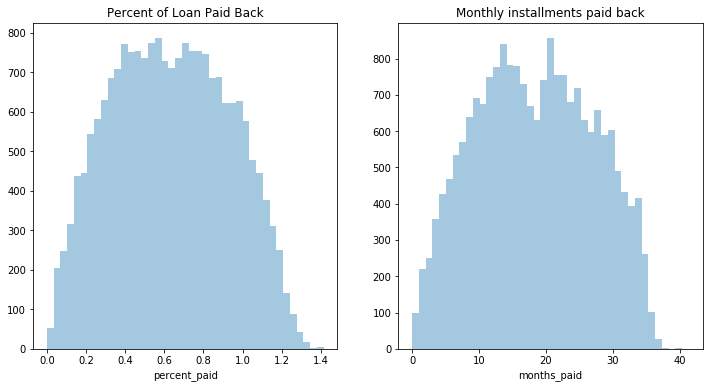

In [27]:
defaults['percent_paid'] = defaults['total_pymnt'] / defaults['funded_amnt']
defaults['months_paid'] = defaults['total_pymnt'] / defaults['installment']

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Percent of Loan Paid Back')
sns.distplot(defaults.percent_paid, kde=False)

plt.subplot(1,2,2)
plt.title('Monthly installments paid back')
sns.distplot(defaults.months_paid, kde=False)

plt.show()

In [28]:
np.mean(defaults.percent_paid)

0.6332227423312397

In [29]:
np.mean(defaults.months_paid)

18.419514318994192

The average amount paid back on loans that defaulted was about 63% of the borrowed amount,or about 18 months' worth of payments. The distributions are relatively normal-looking. Next, we need to find out if this is correlated with any of our factors, so that we can decide how we are going to get a more accurate estimate of the EV of a loan.

In [30]:
defaults[['months_paid', 'ln_annual_inc', 'dti', 'fico_range_high', 'grade', 'sub_grade']].corr()

,months_paid,ln_annual_inc,dti,fico_range_high
months_paid,1.000000,0.058799,-0.014454,0.015209
ln_annual_inc,0.058799,1.000000,-0.160189,0.060964
dti,-0.014454,-0.160189,1.000000,-0.100784
fico_range_high,0.015209,0.060964,-0.100784,1.000000


In [31]:
defaults.groupby(['grade']).mean()[['months_paid', 'percent_paid']]

,months_paid,percent_paid
grade,,
A,19.236454,0.601223
B,19.121627,0.634907
C,18.288675,0.636625
D,17.646575,0.640998
E,16.956214,0.639760
F,15.599550,0.605085
G,12.859937,0.494398


In [32]:
defaults.groupby(['purpose']).mean()[['months_paid', 'percent_paid']]

,months_paid,percent_paid
purpose,,
car,17.724352,0.594081
credit_card,19.397163,0.660663
debt_consolidation,18.521538,0.636630
educational,15.107073,0.508642
home_improvement,18.543849,0.632193
house,17.578606,0.605066
major_purchase,17.387185,0.591261
medical,16.933689,0.594674
moving,16.169274,0.565426


In [33]:
test[['int_rate', 'loan_status', 'pct_return']]

,int_rate,loan_status,pct_return
235833,11.53,Fully Paid,0.069817
236722,7.89,Fully Paid,0.123540
236789,8.18,Charged Off,-0.493941
236812,17.57,Charged Off,-0.327950
237037,18.25,Fully Paid,0.308210
237051,10.99,Charged Off,-0.382258
237072,16.99,Charged Off,-0.201560
237121,7.89,Fully Paid,0.125841
237146,12.29,Fully Paid,0.087310
237155,12.29,Fully Paid,0.200014


In [34]:
def total_int_paid(n, i):
    ii = i/12
    return n*(ii * (1 + ii) ** n) / ((1+ii)**n - 1)-1

total_int_paid(36, .12)

test['total_int_paid'] = test.apply(lambda x: total_int_paid(36, x['int_rate']/100), axis=1)


In [35]:
test['naive_ev_m1'] = test['pred'] * test['total_int_paid'] - (1-test['pred']) * .37
test['naive_ev_m2'] = test['pred2'] * test['total_int_paid'] - (1-test['pred2']) * .37
test['naive_ev_m3'] = test['pred3'] * test['total_int_paid'] - (1-test['pred3']) * .37



In [36]:
for letter in letters:
    thresh_m1_80 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=80)
    thresh_m2_80 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=80)
    thresh_m3_80 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=80)

    thresh_m1_90 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=90)
    thresh_m2_90 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=90)
    thresh_m3_90 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=90)

    thresh_m1_95 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=95)
    thresh_m2_95 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=95)
    thresh_m3_95 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=95)
    
    thresh_m1_99 = np.percentile(test[test.grade == letter]['naive_ev_m1'], q=99)
    thresh_m2_99 = np.percentile(test[test.grade == letter]['naive_ev_m2'], q=99)
    thresh_m3_99 = np.percentile(test[test.grade == letter]['naive_ev_m3'], q=99)

    print('-----------------  ' + letter + '  -----------------')
    print('')
    
    print('Naive Returns:       {}'.format(test[test.grade==letter]['pct_return'].mean()*100))
    
    print('')
    print('Model 1:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m1 >= thresh_m1_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 2:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m2 >= thresh_m2_99)]['pct_return'].mean()*100))
    print('')
    
    print('Model 3:')
    print('>80th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_80)]['pct_return'].mean()*100))
    print('>90th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_90)]['pct_return'].mean()*100))
    print('>95th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_95)]['pct_return'].mean()*100))
    print('>99th percentile:    {}'.format(test[(test.grade==letter)&(test.naive_ev_m3 >= thresh_m3_99)]['pct_return'].mean()*100))

    print('\n')

-----------------  A  -----------------

Naive Returns:       7.141438714524952

Model 1:
>80th percentile:    7.89136792139957
>90th percentile:    8.076954002836393
>95th percentile:    8.465941166350586
>99th percentile:    8.747345590930209

Model 2:
>80th percentile:    8.012574576308133
>90th percentile:    8.358390146277753
>95th percentile:    8.747303905733679
>99th percentile:    8.958812624912829

Model 3:
>80th percentile:    8.029043082931112
>90th percentile:    8.370702897730704
>95th percentile:    8.780136247209265
>99th percentile:    8.953085402613937


-----------------  B  -----------------

Naive Returns:       8.71693709483582

Model 1:
>80th percentile:    10.327449012272268
>90th percentile:    10.815273550718608
>95th percentile:    11.062911856580428
>99th percentile:    11.78829348542587

Model 2:
>80th percentile:    10.531867781668494
>90th percentile:    10.95075425721385
>95th percentile:    11.45608587499968
>99th percentile:    12.480797304444243

Mode